# Линейная регрессия на torch для boston house price

In [1]:
# загружаем данные

!pip3 install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [3]:
!chmod 600 kaggle.json

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d vikrishnan/boston-house-prices

  0% 0.00/12.8k [00:00<?, ?B/s]
100% 12.8k/12.8k [00:00<00:00, 11.6MB/s]


In [6]:
!unzip /content/boston-house-prices.zip

Archive:  /content/boston-house-prices.zip
  inflating: housing.csv             


In [7]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

Названия и описания переменных из описания датасета: 
*   CRIM per capita crime rate by town ZN proportion of residential land zoned for lots over 25,000 sq.ft.
*   INDUS proportion of non-retail business acres per town
*   CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
*   NOX nitric oxides concentration (parts per 10 million)
*   RM average number of rooms per dwelling
*   AGE proportion of owner-occupied units built prior to 1940
*   DIS weighted distances to five Boston employment centres
*   RAD index of accessibility to radial highways
*   TAX full-value property-tax rate per $10,000

*   PTRATIO pupil-teacher ratio by town
*   B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
*   LSTAT % lower status of the population
*   **MEDV Median value of owner-occupied homes in $1000's**

In [8]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'ACE',
         'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [9]:
df = pd.read_csv('housing.csv', sep='\s+', header=None, names=names,
                 dtype='float64')

In [10]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,ACE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [11]:
# нормализуем тестовые данные

df[df.columns[:-1]] = df[df.columns[:-1]].apply(
    lambda x: (x - x.mean()) / x.std()
)

In [12]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,ACE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.419367,0.284548,-1.286636,-0.272329,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,0.440616,-1.074499,24.0
1,-0.416927,-0.487240,-0.592794,-0.272329,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,0.440616,-0.491953,21.6
2,-0.416929,-0.487240,-0.592794,-0.272329,-0.739530,1.281446,-0.265549,0.556609,-0.867024,-0.986353,-0.302794,0.396035,-1.207532,34.7
3,-0.416338,-0.487240,-1.305586,-0.272329,-0.834458,1.015298,-0.809088,1.076671,-0.752178,-1.105022,0.112920,0.415751,-1.360171,33.4
4,-0.412074,-0.487240,-1.305586,-0.272329,-0.834458,1.227362,-0.510674,1.076671,-0.752178,-1.105022,0.112920,0.440616,-1.025487,36.2


In [13]:
# преобразуем X и y в numpy-формат

X = df.drop('MEDV', axis=1).to_numpy()
Y = df['MEDV'].to_numpy()

In [14]:
# разобьём датасет на обучающий и тестовый для оценки качества

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [15]:
X_train.shape

(379, 13)

In [16]:
X_test.shape

(127, 13)

In [17]:
y_train.shape

(379,)

In [18]:
y_test.shape

(127,)

In [19]:
# преобразуем выборки в тензоры

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

In [20]:
# обернём выборки в TensorDataset и DataLoader-ы
# размер батча лучше выбрать 16, а не 8, не только потому, что 16=2^4,
# но и потому, что так обучающая и тестовая выборки (379 и 127 образцов)
# ровнее разбиваются на батчи

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [21]:
model = torch.nn.Sequential(torch.nn.Linear(13, 1))

In [22]:
# инициализуем случайные нормированные через std=0.1 веса и нулевые bias

torch.nn.init.normal_(model[0].weight, mean=0, std=0.1)
torch.nn.init.constant_(model[0].bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

In [23]:
trainer = torch.optim.SGD(model.parameters(), lr=0.05)

In [24]:
loss = torch.nn.MSELoss(reduction='mean')

In [25]:
# сохраним все значения функции потерь и построим график лоссов после завершения обучения

num_epochs = 100
losses = []

for epoch in tqdm(range(1, num_epochs + 1)):
    for x, y in train_loader:
        output = model(x)
        l = loss(output, y)
        losses.append(l.item())
        trainer.zero_grad()
        l.backward()
        trainer.step()

100%|██████████| 100/100 [00:01<00:00, 79.75it/s]


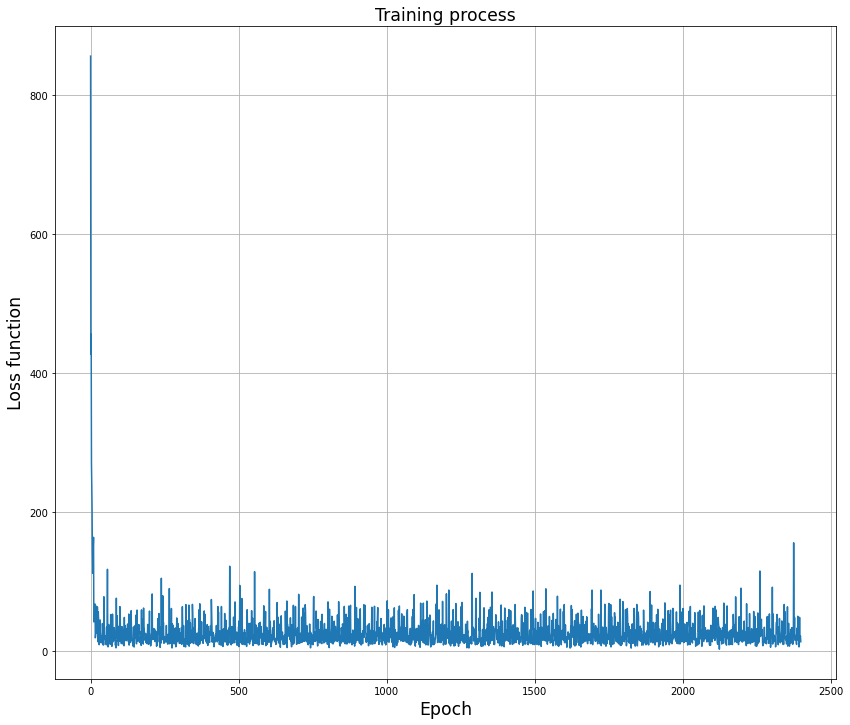

In [26]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

Посчитаем loss для обучающей и для тестовой выборки по завершении обучения.

In [27]:
losses[-1]

13.0542573928833

In [28]:
loss(model(X_test), y_test).item()

28.425460815429688

# Наивный байесовский классификатор для MNIST

Не поняла, почему в задании требуется для классов использовать цифры 1 и 2, когда в самом датасете MNIST используются 0 и 1. В моей реализации классификатор использует метки классов, найденные в датасете (как и все sklearn-овские наивные байесовские классификаторы, в т. ч., GaussianNB, по образцу которого я реализовывала).

In [28]:
import torchvision
from sklearn.naive_bayes import GaussianNB

In [32]:
def transform(data):
    data = torch.tensor(data.getdata(), dtype=torch.float32)
    return torch.floor(data / 128.).squeeze(axis=-1)

In [ ]:
mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform,
                                         download=True)
mnist_test  = torchvision.datasets.MNIST('.', train=False, transform=transform,
                                         download=True)
clear_output()

In [34]:
mnist_train[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0.,

In [35]:
mnist_train[0][0].shape

torch.Size([784])